<a href="https://colab.research.google.com/github/sxzeu/AI/blob/main/Game_AI_STEAM_game_review_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

게임소프트웨어 전공 박정윤 게임인공지능 기말프로젝트입니다.
아래 링크의 네이버 영화평 데이터를 이용한 한국어 감성분석 프로젝트에 기초해 프로젝트를 진행했습니다.

링크 : https://wikidocs.net/44249

In [ ]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 3.4 MB/s 
     |████████████████████████████████| 86 kB 2.2 MB/s 
     |████████████████████████████████| 448 kB 33.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


# 1. 스팀 게임리뷰 데이터 전처리

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sxzeu/AlgorithmStudy/main/gameai/dataset_2.txt", filename="dataset_2.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/sxzeu/AlgorithmStudy/main/gameai/dataset_1.txt", filename="dataset_1.txt")

('dataset_1.txt', <http.client.HTTPMessage at 0x7f6608c01e90>)

In [ ]:
train_data = pd.read_table('dataset_2.txt',sep = '\t', engine='python', encoding='utf-8')
test_data = pd.read_table('dataset_1.txt',sep = '\t',engine='python',encoding='utf-8')

In [ ]:
print('훈련 샘플의 개수 :',len(train_data), train_data.shape) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :',len(test_data), test_data.shape) # 테스트용 리뷰 개수 출력
print(train_data)
print(test_data)

훈련 샘플의 개수 : 500 (500, 3)
테스트 샘플의 개수 : 300 (300, 3)
     num                                             review  po/na
0      1                                       좋은 포션 위대한 포션      1
1      2  게임은 깔끔하게 잘 만들었으나 얻는 즐거움의 심도가 너무 옅다  가격 흥정은 너무 ...      0
2      3                     제작과 판매 자체만으로 재밌게 할 수 있다면 추천한다       1
3      4                                  메뉴판 보고 주문해 이 잡것들아      0
4      5                                       응애 나 애기 포션상인      1
..   ...                                                ...    ...
495  496    발매되자마자 사는데 한글화가 아니어서 아쉽네요 빨리 정식 한글화좀 해주세요 개발자님       1
496  497                                        아버지가 좋아하시네요      1
497  498                                        똥겜은 아닌데 똥같음      0
498  499                                좆같은 게임이다 하지만 계속하게된다      1
499  500  지금 안사면 관 들어가기 전까지 후회합니다   당장 시작하세요   이번 정식 업데이...      1

[500 rows x 3 columns]
     num                                             review  po/na
0      1  원래 주방장이 떠나고 돈벌이와 가게 확장에만 관심있는 젊은 사업가가 들어온 단골

In [ ]:
train_data[:5] # 상위 5개 출력

,num,review,po/na
0,1,좋은 포션 위대한 포션,1
1,2,게임은 깔끔하게 잘 만들었으나 얻는 즐거움의 심도가 너무 옅다 가격 흥정은 너무 ...,0
2,3,제작과 판매 자체만으로 재밌게 할 수 있다면 추천한다,1
3,4,메뉴판 보고 주문해 이 잡것들아,0
4,5,응애 나 애기 포션상인,1


In [ ]:
test_data[:5]

,num,review,po/na
0,1,원래 주방장이 떠나고 돈벌이와 가게 확장에만 관심있는 젊은 사업가가 들어온 단골가게...,0
1,2,개씨발련들아,0
2,3,배틀필드는 1에서 끝났다,0
3,4,이건 내가 알던 배틀필드가 아니야…,0
4,5,이걸 제값주고 산 내 인생이 레전드다,0


In [ ]:
train_data['review'].nunique(), train_data['po/na'].nunique()

(500, 2)

In [ ]:
train_data.drop_duplicates(subset=['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 500


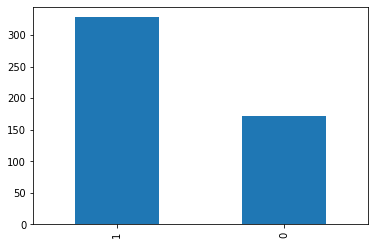

In [ ]:
train_data['po/na'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('po/na').size().reset_index(name = 'count'))

   po/na  count
0      0    172
1      1    328


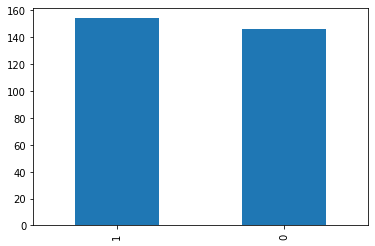

In [ ]:
test_data['po/na'].value_counts().plot(kind = 'bar')

In [ ]:
print(test_data.groupby('po/na').size().reset_index(name = 'count'))

   po/na  count
0      0    146
1      1    154


In [ ]:
print(train_data.isnull().values.any())

False


In [ ]:
print(train_data.isnull().sum())

num       0
review    0
po/na     0
dtype: int64


In [ ]:
train_data.loc[train_data.review.isnull()]

,num,review,po/na


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

500


In [ ]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,num,review,po/na
0,1,좋은 포션 위대한 포션,1
1,2,게임은 깔끔하게 잘 만들었으나 얻는 즐거움의 심도가 너무 옅다 가격 흥정은 너무 ...,0
2,3,제작과 판매 자체만으로 재밌게 할 수 있다면 추천한다,1
3,4,메뉴판 보고 주문해 이 잡것들아,0
4,5,응애 나 애기 포션상인,1


In [ ]:
train_data['review'] = train_data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['review'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

num       0
review    0
po/na     0
dtype: int64


In [ ]:
train_data.loc[train_data.review.isnull()][:5]

,num,review,po/na


In [ ]:
train_data = train_data.dropna(how = 'any')

In [ ]:
print(len(train_data))

500


In [ ]:
test_data.drop_duplicates(subset = ['review'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'] = test_data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 296


In [ ]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 296


In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

In [ ]:
X_train = []
for sentence in tqdm(train_data['review']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 500/500 [00:18<00:00, 26.86it/s] 


In [ ]:
X_test = []
for sentence in tqdm(test_data['review']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 296/296 [00:00<00:00, 372.04it/s]


In [ ]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 296


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'게임': 1, '을': 2, '있다': 3, '재밌다': 4, '없다': 5, '좋다': 6, '되다': 7, '이다': 8, '않다': 9, '겜': 10, '아니다': 11, '것': 12, '친구': 13, '보다': 14, '해보다': 15, '적': 16, '재미있다': 17, '로': 18, '사람': 19, '같다': 20, '수': 21, '시간': 22, '다': 23, '에서': 24, '너무': 25, '더': 26, '때': 27, '고': 28, '재미': 29, '못': 30, '만': 31, '생각': 32, '추천': 33, '인': 34, '많다': 35, '안': 36, '플레이': 37, '나': 38, '정말': 39, '그래픽': 40, '하고': 41, '같이': 42, '갓': 43, '나오다': 44, '만들다': 45, '해주다': 46, '아직': 47, '까지': 48, '가다': 49, '모르다': 50, '거': 51, '들다': 52, '버그': 53, '좋아하다': 54, '돈': 55, '정도': 56, '제발': 57, '쉬움': 58, '함': 59, '즐기다': 60, '말': 61, '그냥': 62, '아': 63, '랑': 64, '되어다': 65, '사다': 66, '등': 67, '게': 68, '진짜': 69, '혼자': 70, '유저': 71, '면': 72, '내': 73, '저': 74, '분': 75, '핵': 76, '명작': 77, '세': 78, '느낌': 79, '자다': 80, '지금': 81, '죽다': 82, '치다': 83, '시작': 84, '처음': 85, '처럼': 86, '매우': 87, '어렵다': 88, '멀티': 89, '가능하다': 90, '개': 91, '노잼': 92, '임': 93, '부분': 94, '아깝다': 95, '이라고': 96, '이랑': 97, 'ㅡ': 98, '발': 99, '위': 100, '다른': 101, '어떻다': 102,

In [ ]:
print(tokenizer.word_counts.items())

odict_items([('좋다', 39), ('포션', 4), ('위대하다', 1), ('게임', 174), ('깔끔하다', 2), ('자다', 8), ('만들다', 13), ('얻다', 1), ('즐거움', 2), ('심다', 1), ('너무', 19), ('옅다', 1), ('가격', 6), ('흥정', 1), ('쉬다', 3), ('고객', 2), ('을', 111), ('사가다', 1), ('뿐', 1), ('이지', 3), ('어떠하다', 1), ('관계', 1), ('형성', 1), ('않다', 32), ('제작', 2), ('또한', 4), ('재료', 1), ('성분', 1), ('필요하다', 5), ('게', 9), ('아니다', 26), ('성질', 1), ('것', 25), ('흥미', 1), ('떨어지다', 6), ('판매', 2), ('자체', 6), ('만으로', 2), ('재밌다', 56), ('수', 22), ('있다', 86), ('추천', 17), ('메뉴판', 1), ('보고', 5), ('주문', 1), ('잡것', 1), ('아', 10), ('응애', 1), ('나', 16), ('애기', 1), ('상', 5), ('인', 17), ('마우스', 3), ('나노', 1), ('컨트롤', 3), ('가능하다', 7), ('짐', 3), ('친구', 25), ('랑', 10), ('없다', 55), ('재미', 18), ('재미없다', 4), ('ㄹㅇ', 5), ('개', 7), ('씹다', 4), ('노잼', 7), ('임', 7), ('진짜', 9), ('로', 23), ('혼자', 9), ('함', 11), ('ㅋㅋ', 4), ('만들어지다', 2), ('업뎃좀', 1), ('더', 19), ('해주다', 13), ('이네', 2), ('컨텐츠', 3), ('부족하다', 4), ('초반', 5), ('에는', 4), ('만해', 3), ('반복', 3), ('노가다', 3), ('질리다', 2), ('성', 6), 

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 1621
등장 빈도가 2번 이하인 희귀 단어의 수: 1249
단어 집합에서 희귀 단어의 비율: 77.0512029611351
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 33.72847237754417


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 373


In [ ]:
tokenizer = Tokenizer(vocab_size) # 빈도수 2 이하인 단어는 제거
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['po/na'])
y_test = np.array(test_data['po/na'])

In [ ]:
print(len(X_train))
print(len(y_train))

500
500


In [ ]:
print(X_train[:3])

[[6, 191, 191], [1, 80, 45, 25, 114, 25, 248, 191, 2, 249, 9, 192, 147, 68, 11, 147, 12, 115], [116, 4, 21, 3, 33]]


In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [ ]:
print(drop_train)

[46, 200, 251, 268, 297, 306, 363, 443]


In [ ]:
len(drop_train)

8

In [ ]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
print(len(X_train))
print(len(y_train))

492
492


In [ ]:
print(len(X_test))
print(len(y_test))

296
296


In [ ]:
X_test = np.delete(X_test, drop_test, axis=0)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
y_test = np.delete(y_test, drop_test, axis=0)

In [ ]:
print(len(X_test))
print(len(y_test))

279
279


리뷰의 최대 길이 : 36
리뷰의 평균 길이 : 6.022357723577236


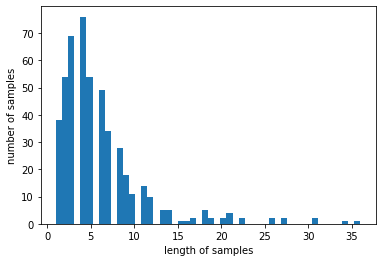

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [ ]:
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.1)

Epoch 1/15
5/7 [====================>.........] - ETA: 0s - loss: 0.6821 - acc: 0.5531 
Epoch 00001: val_acc improved from -inf to 0.64000, saving model to best_model.h5
7/7 [==============================] - 4s 171ms/step - loss: 0.6714 - acc: 0.6041 - val_loss: 0.6469 - val_acc: 0.6400
Epoch 2/15
5/7 [====================>.........] - ETA: 0s - loss: 0.6236 - acc: 0.6781
Epoch 00002: val_acc did not improve from 0.64000
7/7 [==============================] - 0s 19ms/step - loss: 0.6310 - acc: 0.6606 - val_loss: 0.6362 - val_acc: 0.6400
Epoch 3/15
5/7 [====================>.........] - ETA: 0s - loss: 0.6210 - acc: 0.6469
Epoch 00003: val_acc did not improve from 0.64000
7/7 [==============================] - 0s 18ms/step - loss: 0.6108 - acc: 0.6674 - val_loss: 0.6232 - val_acc: 0.6400
Epoch 4/15
5/7 [====================>.........] - ETA: 0s - loss: 0.5719 - acc: 0.6750
Epoch 00004: val_acc did not improve from 0.64000
7/7 [==============================] - 0s 19ms/step - loss: 0.57

In [ ]:
loaded_model = load_model('best_model.h5')

In [ ]:
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

9/9 [==============================] - 1s 5ms/step - loss: 0.6592 - acc: 0.6918

 테스트 정확도: 0.6918


# 3. 리뷰 예측해보기

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('개재밌음')

85.43% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

80.14% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('돈아까움')

66.56% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('노잼')

59.29% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('정말 재밌어요')

95.00% 확률로 긍정 리뷰입니다.

